## Imports


In [1]:
# !pip install Tensorflow
# !pip install Keras
# !pip install scikit-learn
# !pip install imblearn
# !pip install scikeras
# !pip install gensim
# !pip install keras-tuner


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from seaborn import heatmap
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import GRU

from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.utils import set_random_seed

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from gensim.models import Word2Vec
import os
import zipfile
import keras_tuner as kt

from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [3]:
set_random_seed(8)

## Loading the data

In [4]:
df = pd.read_csv('data/processed_data.csv', index_col=0)
df

,headline,is_sarcastic
0,thirtysomething scientists unveil doomsday clo...,1
1,dem rep totally nails congress falling short g...,0
2,eat veggies deliciously different recipes,0
3,inclement weather prevents liar getting work,1
4,mother comes pretty close using word streaming...,1
...,...,...
28614,jews celebrate rosh hashasha something,1
28615,internal affairs investigator disappointed con...,1
28616,beautiful acceptance speech week came queer ko...,0
28617,mars probe destroyed orbiting spielberggates s...,1


In [5]:
df.isna().sum()

headline        2
is_sarcastic    0
dtype: int64

In [6]:
df.dropna(inplace = True)

In [7]:
df.isna().sum()

headline        0
is_sarcastic    0
dtype: int64

In [8]:
df.shape

(28615, 2)

## Splitting data

In [9]:
X = df["headline"]
y = df["is_sarcastic"]

splitting data 70\% train, 10\% validation, 20\% test

In [10]:
#splitting the data into train, validation, test
X, X_test, y, y_test = train_test_split(X,y, test_size = 0.2, random_state = 8)

#splitting the (training) data into training and validating data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.125, random_state = 8)

In [11]:
X_train.sample(5)

11248                 promotional pen covered deadly virus
7318            incredibly boring trait great leaders need
4803         kfc midas team muchanticipated crossover meal
17606        stolen moment week brett davis sally burtnick
21592    race relations forgetting ferguson remembering...
Name: headline, dtype: object

In [12]:
y_train.sample(5)

22619    0
19821    1
3560     0
22091    1
11353    0
Name: is_sarcastic, dtype: int64

## Model statistics

In [13]:
def plotCurves(history, model_name):
    results = pd.DataFrame(history.history)
    
    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(20, 10))
    
    ax1.plot(results.index, results.loss)
    ax1.plot(results.index, results.val_loss)
    ax1.set_title(model_name)
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Binary Crossentropy Loss")
    ax1.legend(["Training Loss", "Validation Loss"])
   


 
    ax2.plot(results.index, results.accuracy)
    ax2.plot(results.index, results.val_accuracy)
    ax2.set_title(model_name)
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    ax2.legend(["Training Accuracy", "Validation Accuracy"])
 

    fig.show()

In [14]:


def printModelStats(model, X, y):

    y_pred = model.predict(X)
    y_pred[y_pred <= 0.5] = 0
    y_pred[y_pred > 0.5] = 1    


    print(classification_report(y, y_pred, target_names = ['Sarcastic', 'Not Sarcastic']))
   
    cm = confusion_matrix(y, y_pred)
    print("The confusion matrix:")
    print(cm)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] 
    sns.heatmap((cm_percent), annot = True, cmap = "Blues").set(title ="Confusion Matrix Expressed in %")

## Tokenizing

In [15]:
tokenizer = Tokenizer(oov_token="<OOV>")

#fitting tokenizer on training set
tokenizer.fit_on_texts(X_train)

#choosing max length to be 20, which is is more than 2*STD +- mean number of words per headline
max_length = 20 # max([len(sentence.split()) for sentence in X_train])

X_train_untk = X_train

In [16]:
#tokenizing headlines
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen = max_length, padding = "post")
X_val = pad_sequences(tokenizer.texts_to_sequences(X_val), maxlen = max_length, padding = "post")
X_test = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen = max_length, padding = "post")

In [17]:
vocab_size = len(tokenizer.word_index)+1
print(f'The size of vocabulary: {vocab_size}')

The size of vocabulary: 24122


## Simple bidirectional LSTM

### Model definition

In [18]:
output_dimension = 100

def buildLSTM1(hp):
    model_lstm = Sequential()
    model_lstm.add(Embedding(input_dim=vocab_size, output_dim=output_dimension, input_length=max_length))
    model_lstm.add(LSTM(hp.Choice('units1', [16, 32, 64])))
    model_lstm.add(Dropout(hp.Choice('rate1', [0.3, 0.5, 0.7])))
    model_lstm.add(Dense(1, activation='sigmoid'))
    model_lstm.summary()
    model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model_lstm


In [19]:

# model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])


In [20]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # The performance measure to monitor
    patience=2,  # How many epochs to wait after the last time the monitored quantity improved
    verbose=1,  # To log when training is being stopped
    mode='min',  # The direction is better when the quantity monitored has stopped decreasing
    restore_best_weights=True  # Whether to restore model weights from the epoch with the best value of the monitored quantity
)


### Model tuning + training

In [21]:
# history = model.fit(X_train, y_train, epochs = 20, batch_size = 32, validation_data=(X_val, y_val),callbacks = early_stopping)


tuner = kt.RandomSearch(buildLSTM1, objective= 'val_loss', seed = 8, max_trials=10, directory= 'models', project_name = 'model_LSTM_proc_1')
tuner.search(X_train, y_train, epochs = 20, batch_size = 32, validation_data = (X_val, y_val), callbacks = [early_stopping])


Trial 9 Complete [00h 00m 54s]
val_loss: 0.4068959355354309

Best val_loss So Far: 0.3926694393157959
Total elapsed time: 00h 07m 48s


In [22]:
best_model = tuner.get_best_models()[0]

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 100)           2412200   
                                                                 
 lstm (LSTM)                 (None, 16)                7488      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 2419705 (9.23 MB)
Trainable params: 2419705 (9.23 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Best model + results

In [23]:
best_hp = tuner.get_best_hyperparameters()[0]
best_model_1 = tuner.hypermodel.build(best_hp)
for param in best_hp.values:
    print(f"{param}: {best_hp.get(param)}")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 20, 100)           2412200   
                                                                 
 lstm_1 (LSTM)               (None, 16)                7488      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 2419705 (9.23 MB)
Trainable params: 2419705 (9.23 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
units1: 16
rate1: 0.3


In [24]:
history = best_model_1.fit(X_train, y_train, epochs = 20, batch_size = 32, validation_data=(X_val, y_val),callbacks = early_stopping)


Epoch 1/20
626/626 [==============================] - 22s 32ms/step - loss: 0.5235 - accuracy: 0.7254 - val_loss: 0.3981 - val_accuracy: 0.8169
Epoch 2/20
626/626 [==============================] - 17s 26ms/step - loss: 0.2649 - accuracy: 0.8957 - val_loss: 0.4332 - val_accuracy: 0.7900
Epoch 3/20
626/626 [==============================] - 16s 26ms/step - loss: 0.1410 - accuracy: 0.9489 - val_loss: 0.5118 - val_accuracy: 0.8033
Epoch 3: early stopping


/var/folders/bk/xxbl1cz50l17bxfff19493v40000gn/T/ipykernel_19674/2336864335.py:24: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


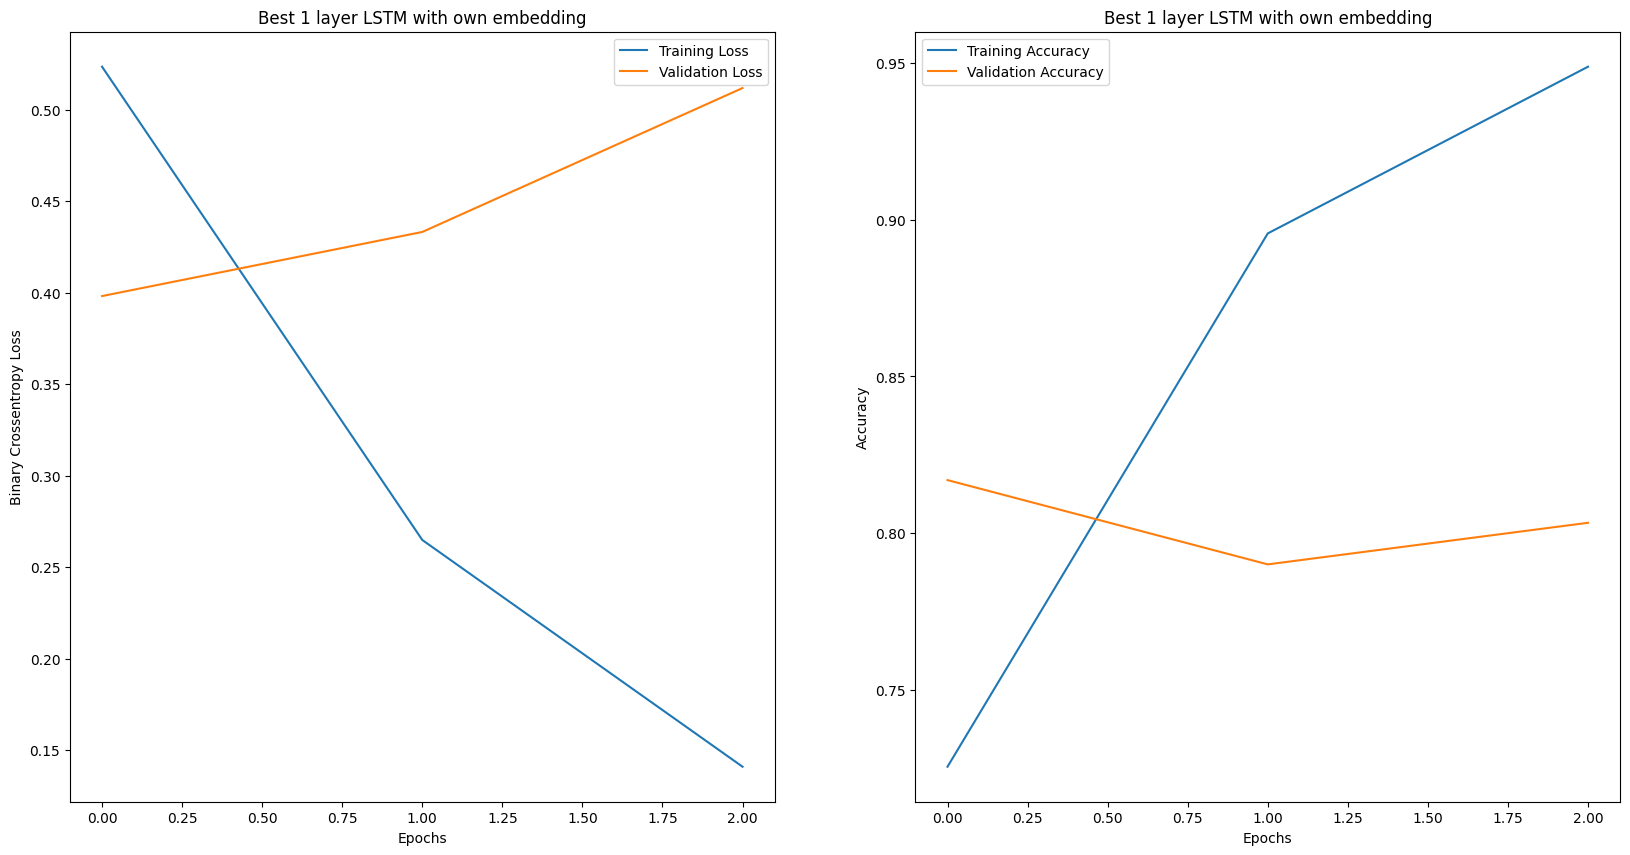

In [25]:
plotCurves(history, "Best 1 layer LSTM with own embedding")

printModelStats(model)

179/179 [==============================] - 1s 5ms/step
               precision    recall  f1-score   support

    Sarcastic       0.84      0.77      0.80      3020
Not Sarcastic       0.76      0.84      0.80      2703

     accuracy                           0.80      5723
    macro avg       0.80      0.81      0.80      5723
 weighted avg       0.81      0.80      0.80      5723

The confusion matrix:
[[2320  700]
 [ 427 2276]]


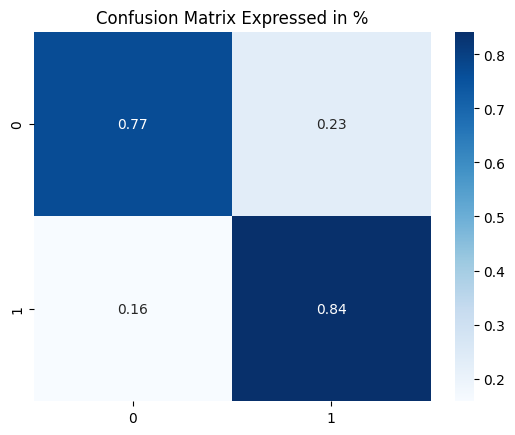

In [26]:
printModelStats(best_model_1, X_test, y_test)

## LSTM with Word2Vec Embedding

In [27]:
output_dimension = 100


#Training Word2Vec embedding layer using Skip grams
sentences = [sentence.split() for sentence in X_train_untk]
w2v = Word2Vec(sentences, vector_size = output_dimension, sg=1)

#Creating the embedding weight matrix
embedding_matrix = np.zeros((vocab_size, output_dimension))

for word, i in tokenizer.word_index.items():
    if word in w2v.wv:
        embedding_matrix[i] = w2v.wv[word]



In [28]:
output_dimension = 100

def LSTM_w2vec(hp):
    model = Sequential()
    model.add(Embedding(input_dim = vocab_size, output_dim = output_dimension, input_length = max_length, weights=[embedding_matrix]))
    model.add(LSTM(hp.Choice('units1', [16,32,64])))
    model.add(Dropout(hp.Choice('rate1', [0.3,0.5, 0.7])))
    model.add(Dense(1, activation = "sigmoid"))
    model.summary()
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    return model

In [29]:
# model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss',  # The performance measure to monitor
    patience=2,  # How many epochs to wait after the last time the monitored quantity improved
    verbose=1,  # To log when training is being stopped
    mode='min',  # The direction is better when the quantity monitored has stopped decreasing
    restore_best_weights=True  # Whether to restore model weights from the epoch with the best value of the monitored quantity
)

In [30]:

tuner = kt.RandomSearch(LSTM_w2vec, objective= 'val_loss', seed = 8, max_trials=9, directory= 'models', project_name = 'model_LSTM_proc_w2v')
tuner.search(X_train, y_train, epochs = 20, batch_size = 32, validation_data = (X_val, y_val), callbacks = [early_stopping])


Trial 9 Complete [00h 01m 00s]
val_loss: 0.39908504486083984

Best val_loss So Far: 0.3887672424316406
Total elapsed time: 00h 08m 45s


In [31]:
best_hp_lstm_w2vec = tuner.get_best_hyperparameters()[0]
best_model_lstm_w2vec = tuner.hypermodel.build(best_hp_lstm_w2vec)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 20, 100)           2412200   
                                                                 
 lstm_1 (LSTM)               (None, 64)                42240     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2454505 (9.36 MB)
Trainable params: 2454505 (9.36 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [32]:
history_lstm_w2vec = best_model_lstm_w2vec.fit(X_train, y_train, epochs = 20, batch_size = 32, validation_data=(X_val, y_val),callbacks = early_stopping)



Epoch 1/20
626/626 [==============================] - 26s 37ms/step - loss: 0.5058 - accuracy: 0.7450 - val_loss: 0.3912 - val_accuracy: 0.8162
Epoch 2/20
626/626 [==============================] - 17s 27ms/step - loss: 0.2255 - accuracy: 0.9132 - val_loss: 0.4434 - val_accuracy: 0.8061
Epoch 3/20
626/626 [==============================] - 16s 25ms/step - loss: 0.1012 - accuracy: 0.9643 - val_loss: 0.6247 - val_accuracy: 0.7959
Epoch 3: early stopping


/var/folders/bk/xxbl1cz50l17bxfff19493v40000gn/T/ipykernel_19674/2336864335.py:24: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


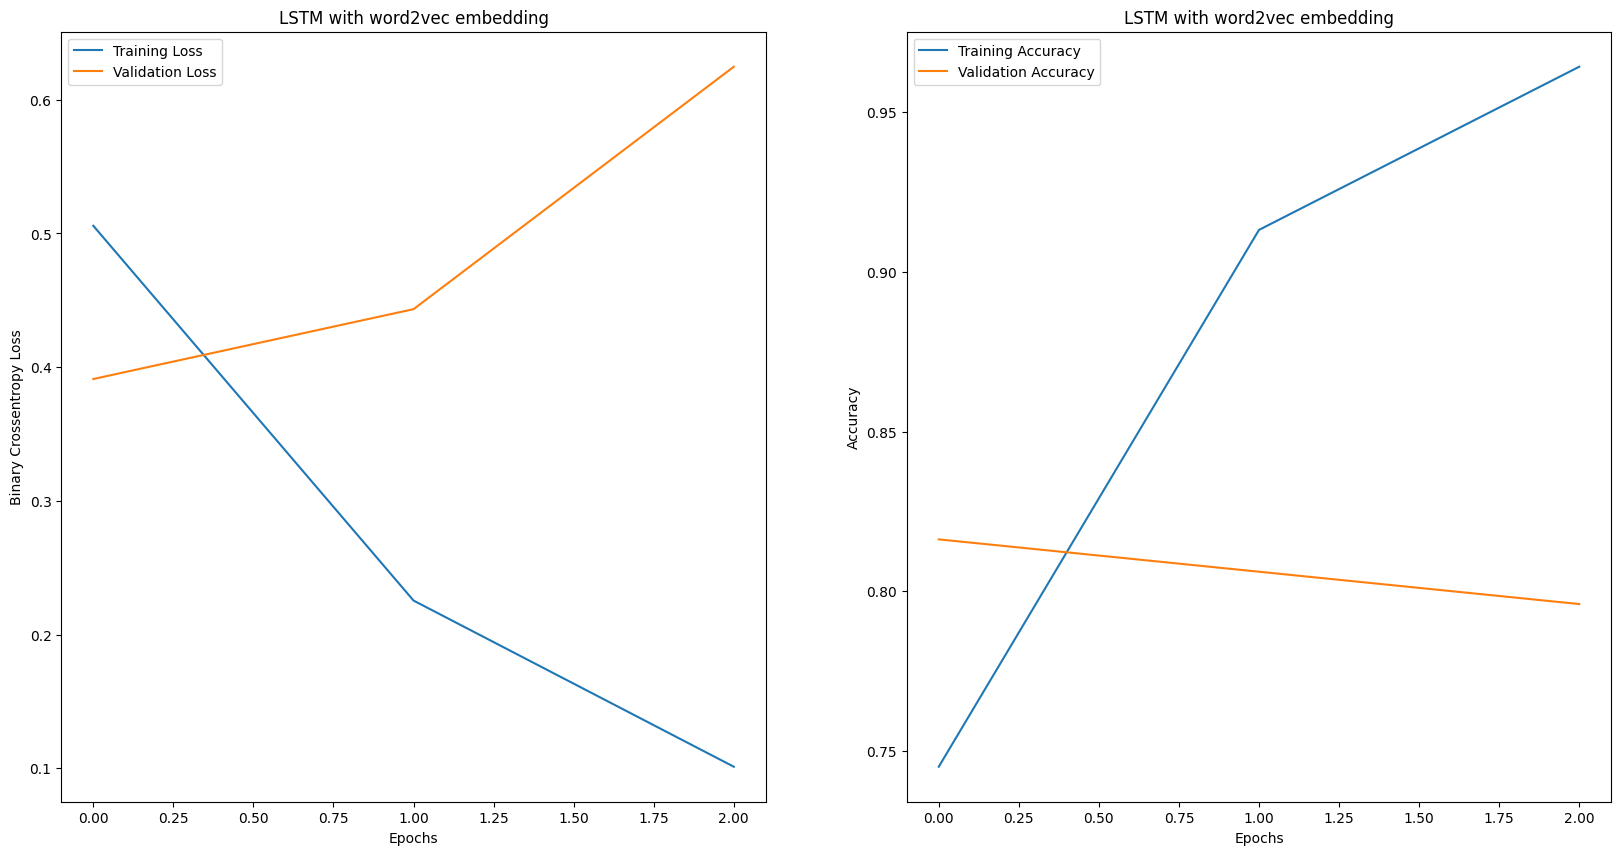

In [33]:
plotCurves(history_lstm_w2vec, "LSTM with word2vec embedding")

179/179 [==============================] - 1s 5ms/step
               precision    recall  f1-score   support

    Sarcastic       0.83      0.80      0.81      3020
Not Sarcastic       0.78      0.82      0.80      2703

     accuracy                           0.81      5723
    macro avg       0.81      0.81      0.81      5723
 weighted avg       0.81      0.81      0.81      5723

The confusion matrix:
[[2401  619]
 [ 481 2222]]


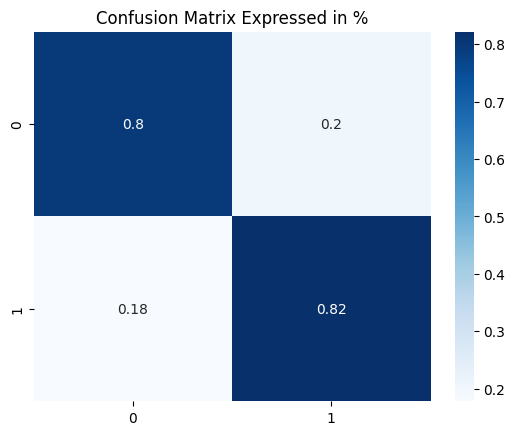

In [34]:
printModelStats(best_model_lstm_w2vec, X_test, y_test)


## With glove embedding

In [35]:

from gensim.scripts.glove2word2vec import glove2word2vec
import gensim.downloader as api

glove_model = api.load("glove-wiki-gigaword-100")

output_dimension = 100
embedding_matrix = np.zeros((vocab_size, output_dimension))

for word, i in tokenizer.word_index.items():
     
    #trying to find word in glove model
    if word in glove_model:
        embedding_matrix[i] = glove_model[word]



In [36]:
output_dimension = 100

def LSTM_glove(hp):
    model_lstm = Sequential()
    model_lstm.add(Embedding(input_dim=vocab_size, output_dim=output_dimension, input_length=max_length))
    model_lstm.add(LSTM(hp.Choice('units1', [16, 32, 64])))
    model_lstm.add(Dropout(hp.Choice('rate1', [0.3, 0.5, 0.7])))
    model_lstm.add(Dense(1, activation='sigmoid'))
    model_lstm.summary()
    model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model_lstm

In [37]:
# model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss',  # The performance measure to monitor
    patience=2,  # How many epochs to wait after the last time the monitored quantity improved
    verbose=1,  # To log when training is being stopped
    mode='min',  # The direction is better when the quantity monitored has stopped decreasing
    restore_best_weights=True  # Whether to restore model weights from the epoch with the best value of the monitored quantity
)

In [38]:

tuner = kt.RandomSearch(LSTM_glove, objective= 'val_loss', seed = 8, max_trials=9, directory= 'models', project_name = 'model_LSTM_proc_glove')
tuner.search(X_train, y_train, epochs = 20, batch_size = 32, validation_data = (X_val, y_val), callbacks = [early_stopping])

Trial 9 Complete [00h 01m 06s]
val_loss: 0.39680469036102295

Best val_loss So Far: 0.39518722891807556
Total elapsed time: 00h 09m 53s


In [39]:
best_hp3 = tuner.get_best_hyperparameters()[0]
best_model_3 = tuner.hypermodel.build(best_hp3)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 20, 100)           2412200   
                                                                 
 lstm_1 (LSTM)               (None, 64)                42240     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2454505 (9.36 MB)
Trainable params: 2454505 (9.36 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [40]:
history = best_model_3.fit(X_train, y_train, epochs = 20, batch_size = 64, validation_data=(X_val, y_val),callbacks = early_stopping)

Epoch 1/20
313/313 [==============================] - 27s 75ms/step - loss: 0.5139 - accuracy: 0.7314 - val_loss: 0.3946 - val_accuracy: 0.8201
Epoch 2/20
313/313 [==============================] - 13s 41ms/step - loss: 0.2549 - accuracy: 0.8974 - val_loss: 0.4422 - val_accuracy: 0.8085
Epoch 3/20
313/313 [==============================] - 12s 39ms/step - loss: 0.1411 - accuracy: 0.9481 - val_loss: 0.5504 - val_accuracy: 0.8008
Epoch 3: early stopping


/var/folders/bk/xxbl1cz50l17bxfff19493v40000gn/T/ipykernel_19674/2336864335.py:24: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


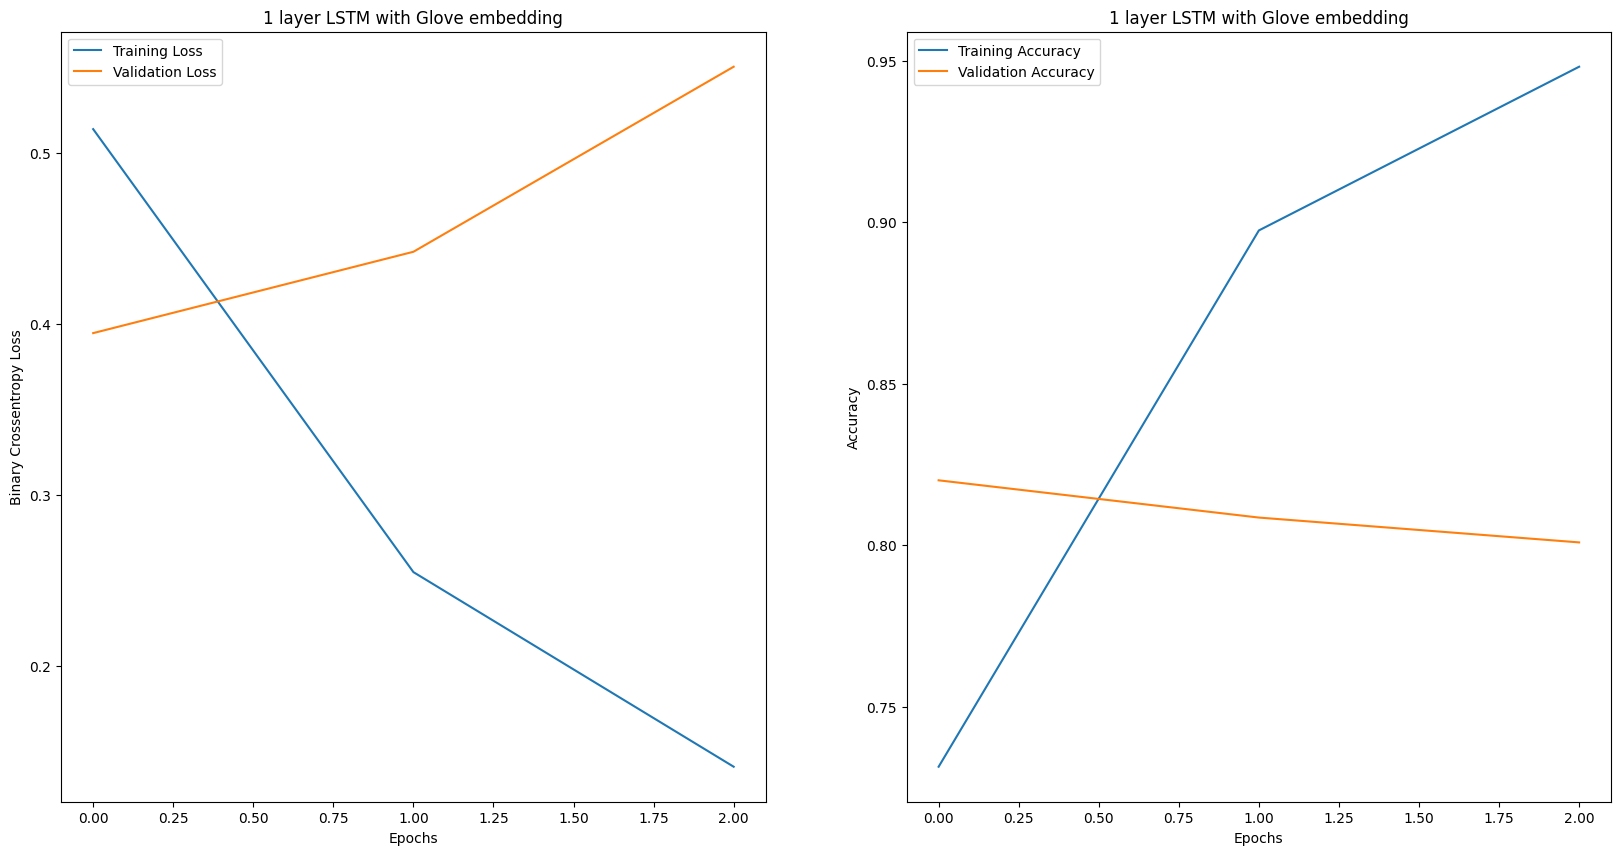

In [41]:
plotCurves(history, "1 layer LSTM with Glove embedding")

179/179 [==============================] - 2s 6ms/step
               precision    recall  f1-score   support

    Sarcastic       0.82      0.81      0.81      3020
Not Sarcastic       0.79      0.80      0.80      2703

     accuracy                           0.81      5723
    macro avg       0.81      0.81      0.81      5723
 weighted avg       0.81      0.81      0.81      5723

The confusion matrix:
[[2445  575]
 [ 536 2167]]


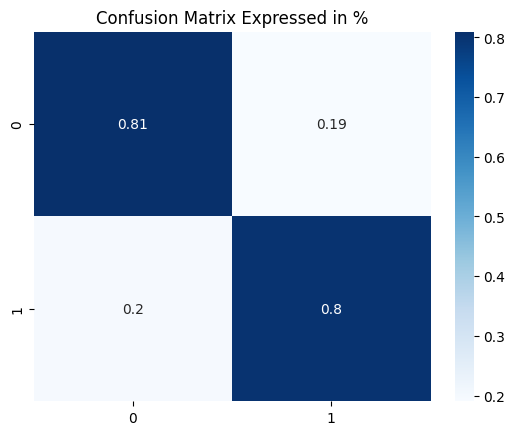

In [42]:
printModelStats(best_model_3, X_test, y_test)